# 📊 GPU-Accelerated Performance Benchmarking
## Colab-Optimised Model Performance Analysis

[![Colab](https://img.shields.io/badge/Platform-Google%20Colab-orange?logo=googlecolab&logoColor=white)]()
[![GPU](https://img.shields.io/badge/Hardware-T4%20GPU-green?logo=nvidia&logoColor=white)]()
[![Performance](https://img.shields.io/badge/Target-Sub%201ms%20Latency-red)]()

---

### 📋 Overview

This notebook provides comprehensive benchmarking of transformer-based models with GPU acceleration in Google Colab. It's designed to achieve sub-1ms latency with the T4 GPU available in Colab.

### 🎯 Key Features

- **🚀 GPU Acceleration**: CUDA and TensorRT optimisation
- **⚡ Mixed Precision**: FP16 for maximum performance
- **🔍 Enhanced Benchmarking**: Outlier detection and statistical analysis
- **📊 Automatic Discovery**: Finds and evaluates all available models
- **📈 Performance Profiling**: Detailed latency and throughput analysis

### 🏗️ Optimisation Stack

- **Hardware**: Google Colab T4 GPU (16GB VRAM)
- **Framework**: PyTorch 2.3.1 with CUDA 11.8
- **Runtime**: ONNX Runtime GPU 1.18.0
- **Acceleration**: TensorRT engine optimisation
- **Precision**: Mixed FP16/FP32 for optimal speed

### 📊 Benchmark Metrics

- **⚡ Latency**: Inference time per sample (target: <1ms)
- **🚀 Throughput**: Samples processed per second
- **💾 Memory Usage**: GPU VRAM utilisation
- **🎯 Accuracy**: Model performance validation
- **📈 Scaling**: Batch size performance analysis

### 🔧 Colab-Specific Features

- **📦 Auto-Setup**: Automatic environment configuration
- **📊 Interactive Visualisations**: Real-time performance plots
- **💾 Result Export**: Download benchmark reports
- **🔄 Model Comparison**: Side-by-side performance analysis

---

**🚀 Quick Start**: Run all cells to automatically set up the environment and benchmark all available models!

## 📋 Initial Setup

First, we'll set up the environment and clone the repository. This notebook is designed to be self-contained, so you can simply run it end-to-end in Colab with full GPU optimisation.

In [ ]:
# Check if we're running in Google Colab
import os
IN_COLAB = 'COLAB_GPU' in os.environ

if IN_COLAB:
    print("🚀 Running in Google Colab environment")
    
    # Check for GPU
    !nvidia-smi
    import torch
    if torch.cuda.is_available():
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
        print(f"   CUDA Version: {torch.version.cuda}")
    else:
        print("⚠️ No GPU found! Please change runtime to GPU (Runtime > Change runtime type > Hardware accelerator > GPU)")
else:
    print("⚠️ Not running in Colab. This notebook is optimised for Google Colab with GPU.")

In [ ]:
# Clone the repository if it doesn't exist
import os

if IN_COLAB:
    # Clone the repository if it's not already cloned
    if not os.path.exists('deepmind_internship'):
        !git clone https://github.com/MMillward2012/deepmind_internship.git
        %cd deepmind_internship
    else:
        %cd deepmind_internship
        !git pull  # Get latest updates
        
    print("✅ Repository cloned successfully")
else:
    # Assume we're already in the repo
    print("📂 Using local repository")

In [ ]:
# 1. Fresh start — remove old installs
!pip uninstall -y torch torchvision torchaudio onnxruntime-gpu onnx numpy

# 2. Install PyTorch that works with Python 3.11 + CUDA 11.8 (T4 GPU)
!pip install torch==2.3.1+cu118 torchvision==0.18.1+cu118 torchaudio==2.3.1 --extra-index-url https://download.pytorch.org/whl/cu118

# 3. Install ONNX Runtime GPU & compatible numpy
!pip install --upgrade --force-reinstall "numpy<2" onnxruntime-gpu==1.18.0

# 4. Rest of your stack
!pip install transformers==4.31.0 datasets accelerate scikit-learn matplotlib seaborn pandas psutil
!pip install tensorrt==8.6.1
!pip install --upgrade --force-reinstall "numpy<2"

# 5. Restart runtime to avoid mixed versions
import os; os.kill(os.getpid(), 9)

# Check PyTorch GPU support
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Check ONNX Runtime providers
import onnxruntime as ort
print(f"ONNXRuntime version: {ort.__version__}")
print(f"Available execution providers: {ort.get_available_providers()}")

In [ ]:
# Set up basic directory structure
import os
from pathlib import Path

# Create necessary directories if they don't exist
for directory in ['config', 'results']:
    Path(directory).mkdir(exist_ok=True)

# Create basic config files if they don't exist
if not os.path.exists('config/pipeline_config.json'):
    import json
    
    config = {
        "benchmarking": {
            "fast_mode": True,
            "target_models": [],
            "exclude_models": [],
            "include_accuracy": True,
            "iterations": {
                "fast": 30,
                "thorough": 50
            },
            "warmup_iterations": {
                "fast": 10,
                "thorough": 20
            },
            "batch_sizes": {
                "fast": [1, 4, 8, 16],
                "thorough": [1, 2, 4, 8, 16, 32]
            },
            "accuracy_sample_size": {
                "fast": 500,
                "thorough": 1000
            },
            "gpu_settings": {
                "use_mixed_precision": True,
                "sequence_length": 32,
                "providers": ["CUDAExecutionProvider", "CPUExecutionProvider"]
            }
        },
        "models": {
            "output_dir": "models"
        }
    }
    
    with open('config/pipeline_config.json', 'w') as f:
        json.dump(config, f, indent=2)
        
    print("✅ Created default config file")
    
if not os.path.exists('config/pipeline_state.json'):
    with open('config/pipeline_state.json', 'w') as f:
        json.dump({"steps_completed": []}, f, indent=2)
    print("✅ Created default state file")

## 🔧 Download Sample Models

If this is the first time running the benchmark, we'll download a sample model to test. For subsequent runs, your models in the `models/` directory will be used.

In [ ]:
# Download a sample model for testing if the models directory is empty
from pathlib import Path
import os

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Check if we have any models
if not any(models_dir.iterdir()):
    print("📥 Downloading sample model for benchmarking...")
    
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    
    # Download a small model for benchmarking - TinyBERT financial classifier
    model_name = "yiyanghkust/finbert-tone"
    output_dir = models_dir / "finbert-tone-financial-sentiment"
    
    print(f"Downloading {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    
    # Save model and tokenizer
    tokenizer.save_pretrained(str(output_dir))
    model.save_pretrained(str(output_dir))
    
    # Create ONNX directory
    onnx_dir = output_dir / "onnx"
    onnx_dir.mkdir(exist_ok=True)
    
    # Simple utility to create a mock ONNX file
    import torch
    print("Converting to ONNX format...")
    
    # Create input examples
    inputs = tokenizer("This is a sample text for ONNX conversion", return_tensors="pt")
    
    # Export to ONNX
    onnx_path = str(onnx_dir / "model.onnx")
    torch.onnx.export(
        model,
        (inputs["input_ids"], inputs["attention_mask"]),
        onnx_path,
        input_names=["input_ids", "attention_mask"],
        output_names=["logits"],
        dynamic_axes={
            "input_ids": {0: "batch_size"},
            "attention_mask": {0: "batch_size"},
            "logits": {0: "batch_size"}
        },
        opset_version=12
    )
    
    print(f"✅ Sample model downloaded and prepared at {output_dir}")
else:
    print(f"✅ Found existing models directory with {sum(1 for _ in models_dir.iterdir() if _.is_dir())} models")

In [ ]:
# Import configuration system and benchmarking utilities
import sys
import os

# Define minimal Pipeline Utils classes for Colab (to avoid requiring the full src module)
class ConfigManager:
    """Simple config manager for the Colab environment."""
    def __init__(self, config_path):
        import json
        self.config_path = config_path
        try:
            with open(config_path, 'r') as f:
                self.config = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            print(f"⚠️ Config file not found or invalid: {config_path}. Using defaults.")
            self.config = {}
    
    def get(self, section, default=None):
        """Get a section from the config, with fallback to default."""
        return self.config.get(section, default)

class StateManager:
    """Simple state manager for the Colab environment."""
    def __init__(self, state_path):
        import json
        self.state_path = state_path
        try:
            with open(state_path, 'r') as f:
                self.state = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            self.state = {"steps_completed": []}
            self._save_state()
    
    def is_step_complete(self, step_name):
        return step_name in self.state.get("steps_completed", [])
    
    def save_state(self, key, value):
        self.state[key] = value
        self._save_state()
    
    def _save_state(self):
        import json
        with open(self.state_path, 'w') as f:
            json.dump(self.state, f, indent=2)

class LoggingManager:
    """Simple logging manager for the Colab environment."""
    def __init__(self, config, logger_name):
        import logging
        self.logger = logging.getLogger(logger_name)
        if not self.logger.handlers:
            self.logger.setLevel(logging.INFO)
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
    
    def get_logger(self):
        return self.logger

# Standard imports
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import time
import gc
import platform
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass, asdict
from collections import defaultdict
import warnings

# Machine Learning imports
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ONNX and optimization imports
try:
    import onnxruntime as ort
    onnx_available = True
except ImportError:
    print("⚠️ ONNXRuntime not installed. Install with: pip install onnxruntime")
    onnx_available = False

# Hugging Face transformers
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import pickle
    transformers_available = True
except ImportError:
    print("⚠️ Transformers not installed")
    transformers_available = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Resource control imports
import psutil

# Initialize managers
config = ConfigManager("config/pipeline_config.json")  # Use local path for Colab
state = StateManager("config/pipeline_state.json")     # Use local path for Colab
logger_manager = LoggingManager(config, 'benchmarking')
logger = logger_manager.get_logger()

# GPU/CPU resource management (optimized for Colab T4)
if torch.cuda.is_available():
    # For GPU systems, allow parallel CPU threads for data prep, but use GPU for inference
    MAX_CPU_THREADS = min(os.cpu_count(), 4)  # Use up to 4 CPU threads for data prep
    print(f"🔧 GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"   🖥️ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")
    print(f"   🧠 CPU threads for data prep: {MAX_CPU_THREADS}")
    
    # Enable GPU optimizations
    torch.backends.cudnn.benchmark = True  # Optimize CUDNN
    print(f"   ⚡ CUDNN Benchmark enabled for maximum GPU performance")
else:
    # For CPU-only systems, limit threads to avoid overload
    MAX_CPU_THREADS = min(os.cpu_count(), 2)  # Limit to 2 cores for CPU-only
    print(f"⚠️ No GPU detected, running in CPU-only mode (performance will be limited)")
    print(f"   🖥️ CPU threads limited to: {MAX_CPU_THREADS}")

# Set CPU thread limits (mostly relevant for CPU-only mode)
os.environ['OMP_NUM_THREADS'] = str(MAX_CPU_THREADS)
os.environ['MKL_NUM_THREADS'] = str(MAX_CPU_THREADS)
os.environ['NUMEXPR_NUM_THREADS'] = str(MAX_CPU_THREADS)
torch.set_num_threads(MAX_CPU_THREADS)

print(f"   💾 Available memory: {psutil.virtual_memory().available / (1024**3):.1f}GB")

logger.info("📊 Starting GPU-Accelerated Performance Benchmarking")
print("📋 Configuration loaded from config/pipeline_config.json")

2025-08-09 21:39:25,524 - pipeline.benchmarking - INFO - 📊 Starting Performance Benchmarking - Generalized Pipeline


🔧 Resource limits applied:
   🖥️ CPU threads: 2
   💾 Available memory: 1.2GB
📋 Configuration loaded from ../config/pipeline_config.json


In [ ]:
# Benchmarking Data Structures and Configuration
@dataclass
class BenchmarkResult:
    """Structured class to hold results from a single benchmark run."""
    model_name: str
    model_type: str  # 'pytorch' or 'onnx'
    batch_size: int
    avg_latency_ms: float
    p50_latency_ms: float
    p95_latency_ms: float
    p99_latency_ms: float
    throughput_samples_per_sec: float
    peak_memory_mb: float
    model_size_mb: float
    provider: str
    accuracy: Optional[float] = None
    f1_score: Optional[float] = None
    weighted_accuracy: Optional[float] = None
    weighted_f1_score: Optional[float] = None
    avg_confidence_correct: Optional[float] = None
    avg_confidence_incorrect: Optional[float] = None
    per_class_metrics: Optional[Dict] = None
    validation_samples: Optional[int] = None
    
    # Enhanced metrics
    std_latency_ms: Optional[float] = None
    min_latency_ms: Optional[float] = None
    max_latency_ms: Optional[float] = None
    avg_memory_mb: Optional[float] = None
    memory_overhead_mb: Optional[float] = None
    efficiency_score: Optional[float] = None  # throughput / model_size_mb
    latency_stability: Optional[float] = None  # coefficient of variation (lower is better)
    memory_efficiency: Optional[float] = None  # throughput / peak_memory_mb
    
    def to_dict(self) -> Dict:
        """Convert to dictionary with flattened per-class metrics."""
        flat_dict = asdict(self)
        per_class = flat_dict.pop("per_class_metrics", {})
        if per_class:
            for class_name, metrics in per_class.items():
                for metric_name, value in metrics.items():
                    flat_dict[f"{class_name}_{metric_name}"] = value
        
        # Calculate derived metrics
        if flat_dict.get('throughput_samples_per_sec') and flat_dict.get('model_size_mb'):
            flat_dict['efficiency_score'] = flat_dict['throughput_samples_per_sec'] / flat_dict['model_size_mb']
        if flat_dict.get('std_latency_ms') and flat_dict.get('avg_latency_ms'):
            flat_dict['latency_stability'] = flat_dict['std_latency_ms'] / flat_dict['avg_latency_ms']  # CV
        if flat_dict.get('throughput_samples_per_sec') and flat_dict.get('peak_memory_mb') and flat_dict['peak_memory_mb'] > 0:
            flat_dict['memory_efficiency'] = flat_dict['throughput_samples_per_sec'] / flat_dict['peak_memory_mb']
            
        return flat_dict

class ExecutionProviderManager:
    """Enhanced ONNX execution provider manager for GPU benchmarking."""
    
    @staticmethod
    def get_execution_providers() -> List[str]:
        """Get available execution providers prioritizing GPU acceleration."""
        if not onnx_available:
            return []
            
        providers = []
        gpu_settings = benchmark_config.get('gpu_settings', {})
        
        # Check for GPU providers
        if torch.cuda.is_available():
            # Check for TensorRT (highest performance)
            if 'TensorrtExecutionProvider' in ort.get_available_providers():
                providers.append('TensorrtExecutionProvider')
                print("🚀 TensorRT available - expect sub-1ms latency!")
            
            # Add CUDA provider (still excellent)
            if 'CUDAExecutionProvider' in ort.get_available_providers():
                providers.append('CUDAExecutionProvider')
                print("✅ CUDA provider enabled for GPU acceleration")
        
        # Always add CPU as fallback
        providers.append('CPUExecutionProvider')
        
        # Use configured providers if specified
        configured_providers = gpu_settings.get('providers', [])
        if configured_providers:
            # Filter to only include available providers
            available_configured = [p for p in configured_providers if p in ort.get_available_providers()]
            if available_configured:
                return available_configured
        
        return providers

# Load benchmarking configuration
benchmark_config = config.get('benchmarking', {})
models_config = config.get('models', {})
data_config = config.get('data', {})

# Resource-aware configuration - All settings loaded from config file
FAST_MODE = benchmark_config.get('fast_mode', True)
TARGET_MODELS = benchmark_config.get('target_models', [])  # Load from config, fallback to empty list (test all models)
EXCLUDE_MODELS = benchmark_config.get('exclude_models', [])  # Load from config, fallback to empty list (exclude none)
INCLUDE_ACCURACY = benchmark_config.get('include_accuracy', True)  # Enable accuracy by default for better insights

print("📊 Benchmarking Configuration:")
print(f"   ⚡ Fast mode: {FAST_MODE}")
print(f"   🎯 Target models: {TARGET_MODELS if TARGET_MODELS else 'All available models'}")
print(f"   ❌ Excluded models: {EXCLUDE_MODELS if EXCLUDE_MODELS else 'None'}")
print(f"   🔧 CPU threads limited to: {MAX_CPU_THREADS}")
print(f"   📊 Include accuracy: {INCLUDE_ACCURACY}")

# Performance parameters - Resource-optimized for development environment

# Performance parameters - Resource-optimized for development environment
if FAST_MODE:
    ITERATIONS = benchmark_config.get('iterations', {}).get('fast', 15)  # Increased for better precision
    WARMUP_ITERATIONS = benchmark_config.get('warmup_iterations', {}).get('fast', 5)  # Increased warmup
    BATCH_SIZES = benchmark_config.get('batch_sizes', {}).get('fast', [1, 4])  # Reduced batch sizes
    ACCURACY_SAMPLE_SIZE = benchmark_config.get('accuracy_sample_size', {}).get('fast', 500)  # Increased for better accuracy measurement
else:
    ITERATIONS = benchmark_config.get('iterations', {}).get('thorough', 30)  # Increased for precision
    WARMUP_ITERATIONS = benchmark_config.get('warmup_iterations', {}).get('thorough', 10)  # More warmup
    BATCH_SIZES = benchmark_config.get('batch_sizes', {}).get('thorough', [1, 4, 8])  # Reduced batch sizes
    ACCURACY_SAMPLE_SIZE = benchmark_config.get('accuracy_sample_size', {}).get('thorough', 1000)  # Large sample for thorough mode

print(f"   🔄 Iterations: {ITERATIONS} (warmup: {WARMUP_ITERATIONS})")
print(f"   📊 Batch sizes: {BATCH_SIZES}")
print(f"   🎯 Accuracy samples: {ACCURACY_SAMPLE_SIZE if INCLUDE_ACCURACY else 'Disabled'}")

logger.info("Benchmarking configuration loaded successfully")

2025-08-09 21:39:25,555 - pipeline.benchmarking - INFO - Benchmarking configuration loaded successfully


📊 Benchmarking Configuration:
   ⚡ Fast mode: True
   🎯 Target models: ['finbert-tone-financial-sentiment', 'tinybert-financial-classifier', 'tinybert-financial-classifier-fine-tuned', 'distilbert-financial-sentiment', 'all-MiniLM-L6-v2-financial-sentiment']
   ❌ Excluded models: ['SmolLM2-360M-Instruct-financial-sentiment']
   🔧 CPU threads limited to: 2
   📊 Include accuracy: True
   🔄 Iterations: 15 (warmup: 5)
   📊 Batch sizes: [1, 4]
   🎯 Accuracy samples: 500


## 🔧 Configuration-Driven Benchmarking

All benchmarking parameters are now loaded from `../config/pipeline_config.json` under the `benchmarking` section:

- **`target_models`**: Specify which models to benchmark (empty list = test all available models)
- **`exclude_models`**: Models to explicitly exclude from benchmarking  
- **`fast_mode`**: Toggle between fast and thorough benchmarking modes
- **`include_accuracy`**: Enable/disable accuracy evaluation during benchmarking
- **`iterations`** & **`warmup_iterations`**: Control precision vs. speed trade-off
- **`batch_sizes`**: Batch sizes to test for each model
- **`accuracy_sample_size`**: Number of samples for accuracy evaluation

**Validation Data**: Uses actual datasets from `../data/processed/validation.csv` or `../data/FinancialPhraseBank/all-data.csv` for realistic accuracy measurements.

This approach makes it easy to customize benchmarking without code changes!

In [ ]:
# Prepare validation data
import os
from pathlib import Path

print("🔍 Checking for validation datasets...")
data_dir = Path("data")

# Create data directories
data_dir.mkdir(exist_ok=True)
(data_dir / "processed").mkdir(exist_ok=True)
(data_dir / "FinancialPhraseBank").mkdir(exist_ok=True)

# Check if we need to download sample validation data
if not (data_dir / "FinancialPhraseBank" / "all-data.csv").exists():
    print("📥 Downloading sample financial sentiment dataset...")
    
    # Create a simple synthetic dataset for validation
    import pandas as pd
    
    # Create synthetic financial sentiment data
    data = {
        'label': ['positive', 'negative', 'neutral'] * 100,
        'text': []
    }
    
    # Create synthetic texts
    positive_templates = [
        "The company reported strong growth of {0}%.",
        "Earnings exceeded expectations by {0}%.",
        "Revenue grew by {0}% in the latest quarter.",
        "Analysts upgraded the stock after {0}% profit increase.",
        "The merger resulted in {0}% cost savings."
    ]
    
    negative_templates = [
        "The company reported losses of {0}%.",
        "Stock price fell by {0}% following the announcement.",
        "Revenue declined {0}% year-over-year.",
        "Analysts downgraded the stock after {0}% profit decrease.",
        "The company missed earnings estimates by {0}%."
    ]
    
    neutral_templates = [
        "The company maintained its {0}% market share.",
        "Earnings were in line with the forecast of {0}%.",
        "The stock price fluctuated within {0}% throughout the day.",
        "Analysts maintained their neutral rating with {0}% target.",
        "The quarterly results showed stable growth of {0}%."
    ]
    
    import random
    
    for i in range(300):
        label = data['label'][i]
        if label == 'positive':
            template = random.choice(positive_templates)
            value = random.randint(5, 30)
        elif label == 'negative':
            template = random.choice(negative_templates)
            value = random.randint(5, 30)
        else:  # neutral
            template = random.choice(neutral_templates)
            value = random.randint(1, 5)
            
        data['text'].append(template.format(value))
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Save as all-data.csv
    df.to_csv(data_dir / "FinancialPhraseBank" / "all-data.csv", index=False, header=False)
    
    # Also save a validation.csv
    df.to_csv(data_dir / "processed" / "validation.csv", index=False)
    
    print(f"✅ Created sample datasets with {len(df)} examples")
else:
    print("✅ Validation datasets already exist")

# Model Discovery and Loading
logger.info("🔍 Discovering available models...")

# Verify prerequisites
if not onnx_available or not transformers_available:
    raise ImportError("Required libraries missing. Install with: pip install onnxruntime transformers")

# Check if ONNX conversion was completed
if not state.is_step_complete('onnx_conversion_completed'):
    print("⚠️ ONNX conversion not completed. ONNX benchmarks will be skipped.")
    onnx_conversion_completed = False
else:
    onnx_conversion_completed = True

models_dir = Path(models_config.get('output_dir', 'models'))  # Use local path for Colab
print(f"📂 Models directory: {models_dir}")

# Discover available models
available_models = {}

if models_dir.exists():
    for model_path in models_dir.iterdir():
        if not model_path.is_dir() or model_path.name.startswith('.'):
            continue
            
        model_name = model_path.name
        
        # Check if model should be excluded
        if any(excluded in model_name for excluded in EXCLUDE_MODELS):
            print(f"   ❌ Excluding {model_name} (in exclusion list)")
            continue
        
        # Check if model should be included based on TARGET_MODELS
        # If TARGET_MODELS is empty, include all models (except excluded ones)
        if TARGET_MODELS and model_name not in TARGET_MODELS:
            print(f"   ⏭️ Skipping {model_name} (not in target list)")
            continue
        
        # Check for PyTorch model files
        config_file = model_path / "config.json"
        pytorch_files = list(model_path.glob("*.safetensors")) + list(model_path.glob("pytorch_model.bin"))
        
        # Check for ONNX model files
        onnx_dir = model_path / "onnx"
        onnx_files = list(onnx_dir.glob("*.onnx")) if onnx_dir.exists() else []
        
        if config_file.exists() and (pytorch_files or onnx_files):
            model_info = {
                'name': model_name,
                'path': model_path,
                'config_file': config_file,
                'has_pytorch': len(pytorch_files) > 0,
                'has_onnx': len(onnx_files) > 0,
                'pytorch_files': pytorch_files,
                'onnx_files': onnx_files
            }
            available_models[model_name] = model_info
            
            status = []
            if model_info['has_pytorch']:
                status.append("PyTorch")
            if model_info['has_onnx']:
                status.append("ONNX")
            
            print(f"   ✅ Found: {model_name} ({', '.join(status)})")
        else:
            print(f"   ⚠️ Invalid model directory: {model_name}")

print(f"\n📊 Discovery Summary:")
print(f"   🤖 Total models found: {len(available_models)}")
pytorch_count = sum(1 for m in available_models.values() if m['has_pytorch'])
onnx_count = sum(1 for m in available_models.values() if m['has_onnx'])
print(f"   🔥 PyTorch models: {pytorch_count}")
print(f"   ⚡ ONNX models: {onnx_count}")

if len(available_models) == 0:
    logger.error("No models found for benchmarking")
    raise RuntimeError("No models found. Please run model training and/or ONNX conversion first.")

2025-08-09 21:39:25,572 - pipeline.benchmarking - INFO - 🔍 Discovering available models...


📂 Models directory: ../models
   ✅ Found: tinybert-financial-classifier-fine-tuned (PyTorch, ONNX)
   ✅ Found: all-MiniLM-L6-v2-financial-sentiment (PyTorch, ONNX)
   ✅ Found: distilbert-financial-sentiment (PyTorch, ONNX)
   ✅ Found: finbert-tone-financial-sentiment (PyTorch, ONNX)
   ❌ Excluding SmolLM2-360M-Instruct-financial-sentiment (in exclusion list)
   ✅ Found: tinybert-financial-classifier (PyTorch, ONNX)
   ⏭️ Skipping tinybert-financial-classifier-pruned (not in target list)
   ⏭️ Skipping mobilebert-uncased-financial-sentiment (not in target list)

📊 Discovery Summary:
   🤖 Total models found: 5
   🔥 PyTorch models: 5
   ⚡ ONNX models: 5


In [ ]:
# Core Benchmarking Engine
class ModelBenchmarker:
    """Comprehensive model benchmarking with standardized measurement."""
    
    def __init__(self, logger):
        self.logger = logger
        self.execution_providers = ExecutionProviderManager.get_execution_providers()
    
    def measure_memory_usage(self) -> float:
        """Measure current memory usage in MB."""
        import psutil
        process = psutil.Process()
        return process.memory_info().rss / 1024 / 1024  # Convert to MB
    
    def get_model_size(self, model_path: Path, model_type: str) -> float:
        """Get model file size in MB."""
        if model_type == 'pytorch':
            model_files = list(model_path.glob("*.safetensors")) + list(model_path.glob("pytorch_model.bin"))
            return sum(f.stat().st_size for f in model_files) / (1024 * 1024)
        elif model_type == 'onnx':
            onnx_files = list((model_path / "onnx").glob("*.onnx"))
            return sum(f.stat().st_size for f in onnx_files) / (1024 * 1024)
        return 0.0
    
    def create_sample_batch(self, tokenizer, batch_size: int, max_length: int = None) -> Tuple[Any, Any]:
        """Create an optimized sample batch for GPU benchmarking."""
        # Get GPU-optimized sequence length from config
        if max_length is None:
            gpu_settings = benchmark_config.get('gpu_settings', {})
            max_length = gpu_settings.get('sequence_length', 32)  # Shorter sequences for faster inference
        
        # Use short but representative financial texts for maximum speed
        sample_texts = [
            "earnings exceeded expectations",  # Positive sentiment, very short (3 tokens)
            "stock price fell sharply",         # Negative sentiment, very short (3 tokens)
            "quarterly revenue unchanged",      # Neutral sentiment, very short (3 tokens)
            "profits grew ten percent",         # Positive sentiment, very short (4 tokens)
            "market volatility increased"       # Negative/neutral, very short (3 tokens)
        ] * (batch_size // 5 + 1)  # Repeat to fill batch
        
        sample_texts = sample_texts[:batch_size]
        
        # Tokenize inputs with GPU optimization
        inputs = tokenizer(
            sample_texts,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Use mixed precision if configured and on GPU
        use_mixed_precision = benchmark_config.get('gpu_settings', {}).get('use_mixed_precision', False)
        
        if torch.cuda.is_available():
            # Move tensors to GPU directly
            input_ids = inputs['input_ids'].cuda()
            attention_mask = inputs['attention_mask'].cuda()
            
            # Apply mixed precision if enabled
            if use_mixed_precision:
                input_ids = input_ids.to(torch.int32)  # Keep input_ids as int32
                attention_mask = attention_mask.to(torch.float16)  # Half precision for attention mask
                self.logger.debug("Using mixed precision (FP16) for benchmarking")
        else:
            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']
            
        return input_ids, attention_mask
    
    def get_validation_dataset(self):
        """Load the actual validation dataset from the data folder."""
        try:
            import pandas as pd
            
            # Load validation data from the processed dataset
            validation_path = Path("data/processed/validation.csv")
            
            if not validation_path.exists():
                # Fallback to main dataset if processed validation doesn't exist
                self.logger.info("Processed validation set not found, using main dataset")
                validation_path = Path("data/FinancialPhraseBank/all-data.csv")
                
                # For Colab: if datasets don't exist, use synthetic data
                if not validation_path.exists():
                    self.logger.info("No validation datasets found in Colab, using synthetic data")
                    raise FileNotFoundError("No validation datasets found")
                
                # Load and process the main dataset
                df = pd.read_csv(validation_path, header=None, names=['label', 'text'])
                
                # Convert string labels to numeric
                label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
                df['label_numeric'] = df['label'].map(label_mapping)
                
                # Remove any rows with unmapped labels
                df = df.dropna(subset=['label_numeric'])
                
                # Take a sample for validation (20% of data)
                sample_size = min(1000, len(df) // 5)  # Max 1000 samples
                df_sample = df.sample(n=sample_size, random_state=42)
                
                validation_texts = df_sample['text'].tolist()
                validation_labels = df_sample['label_numeric'].astype(int).tolist()
                
            else:
                # Load processed validation dataset
                self.logger.info(f"Loading validation dataset from {validation_path}")
                df = pd.read_csv(validation_path)
                
                # Convert string labels to numeric if needed
                if df['label'].dtype == 'object':
                    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
                    df['label_numeric'] = df['label'].map(label_mapping)
                else:
                    df['label_numeric'] = df['label']
                
                # Remove any rows with unmapped labels
                df = df.dropna(subset=['label_numeric'])
                
                validation_texts = df['text'].tolist()
                validation_labels = df['label_numeric'].astype(int).tolist()
            
            self.logger.info(f"Loaded {len(validation_texts)} validation samples")
            self.logger.info(f"Label distribution: {pd.Series(validation_labels).value_counts().sort_index().to_dict()}")
            
            return validation_texts, validation_labels
            
        except Exception as e:
            self.logger.warning(f"Failed to load validation dataset: {e}")
            self.logger.info("Falling back to synthetic validation data")
            
            # Fallback to a smaller synthetic dataset if file loading fails
            validation_texts = [
                # Positive examples (label 2)
                "The company reported strong quarterly earnings with revenue up 15%.",
                "Outstanding dividend yield and consistent earnings growth attract investors.",
                "Record-breaking sales figures demonstrate robust business performance.",
                "The acquisition strategy delivers impressive synergies and cost savings.",
                
                # Negative examples (label 0)
                "Poor quarterly results and disappointing earnings guidance concern investors.",
                "High debt levels and deteriorating credit ratings raise serious concerns.",
                "The company struggles with intense competitive pressure and pricing wars.",
                "Declining profit margins and rising operational costs pressure performance.",
                
                # Neutral examples (label 1)
                "The company announced routine quarterly earnings in line with expectations.",
                "Management provides standard guidance for upcoming fiscal year planning.",
                "The industry shows typical seasonal patterns in demand and supply dynamics.",
                "The company files quarterly reports with standard financial disclosure requirements."
            ]
            
            validation_labels = [2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1]
            
            return validation_texts, validation_labels
    
    def benchmark_pytorch_model(self, model_info: Dict, batch_size: int) -> BenchmarkResult:
        """Benchmark PyTorch model performance with comprehensive metrics and isolated latency measurement."""
        model_name = model_info['name']
        model_path = model_info['path']
        
        # Measure baseline memory before loading model
        baseline_memory = self.measure_memory_usage()
        
        # Load model and tokenizer
        tokenizer = AutoTokenizer.from_pretrained(str(model_path))
        model = AutoModelForSequenceClassification.from_pretrained(str(model_path))
        model.eval()
        
        # Move to appropriate device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
        # Measure memory after loading model
        memory_after_loading = self.measure_memory_usage()
        memory_overhead = memory_after_loading - baseline_memory
        
        # Create sample inputs for benchmarking
        input_ids, attention_mask = self.create_sample_batch(tokenizer, batch_size)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        # === ENHANCED LATENCY MEASUREMENT ===
        # Extended warmup to eliminate JIT effects and stabilize performance
        self.logger.debug(f"Starting extended warmup for {model_name}")
        with torch.no_grad():
            # Initial warmup runs
            for _ in range(WARMUP_ITERATIONS):
                _ = model(input_ids, attention_mask)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
            
            # Force garbage collection before measurement
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
            
            # Additional stabilization runs to eliminate any remaining JIT effects
            for _ in range(5):
                _ = model(input_ids, attention_mask)
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
        
        # Robust latency benchmark with outlier detection
        self.logger.debug(f"Starting robust latency measurement for {model_name}")
        latencies = []
        
        with torch.no_grad():
            for iteration in range(ITERATIONS * 2):  # Collect more samples for outlier filtering
                # Micro-GC every 5 iterations to prevent memory pressure spikes
                if iteration % 5 == 0:
                    gc.collect()
                
                # Clear any lingering operations
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                
                # High-precision timing with multiple sub-measurements
                timings = []
                for _ in range(3):  # Take 3 measurements per iteration
                    start_time = time.perf_counter()
                    outputs = model(input_ids, attention_mask)
                    if torch.cuda.is_available():
                        torch.cuda.synchronize()
                    end_time = time.perf_counter()
                    
                    timings.append((end_time - start_time) * 1000)  # Convert to ms
                    del outputs
                
                # Use median of 3 timings to reduce noise
                latencies.append(np.median(timings))
        
        # === PHASE 2: MEMORY TRACKING ===
        # Separate memory measurement to avoid interfering with latency
        self.logger.debug(f"Starting memory measurement for {model_name}")
        memory_readings = []
        
        with torch.no_grad():
            for _ in range(min(ITERATIONS // 2, 10)):  # Fewer iterations for memory tracking
                # Clear cache and measure memory before iteration
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
                memory_before = self.measure_memory_usage()
                
                outputs = model(input_ids, attention_mask)
                
                memory_after = self.measure_memory_usage()
                memory_readings.append(memory_after)
                
                del outputs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        # Outlier removal using IQR method for more robust statistics
        latencies = np.array(latencies)
        Q1 = np.percentile(latencies, 25)
        Q3 = np.percentile(latencies, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter outliers
        filtered_latencies = latencies[(latencies >= lower_bound) & (latencies <= upper_bound)]
        
        # Log outlier information
        outlier_count = len(latencies) - len(filtered_latencies)
        if outlier_count > 0:
            self.logger.debug(f"Removed {outlier_count} outliers from {len(latencies)} measurements for {model_name}")
        
        # Use filtered data for statistics (minimum 50% of samples must remain)
        if len(filtered_latencies) >= len(latencies) * 0.5:
            final_latencies = filtered_latencies
            self.logger.debug(f"Using {len(final_latencies)} filtered measurements for {model_name}")
        else:
            final_latencies = latencies
            self.logger.warning(f"Too many outliers detected for {model_name}, using all {len(latencies)} measurements")
        
        # Calculate comprehensive latency statistics from filtered data
        final_latencies = np.array(final_latencies)
        avg_latency = np.mean(final_latencies)
        std_latency = np.std(final_latencies)
        min_latency = np.min(final_latencies)
        max_latency = np.max(final_latencies)
        p50_latency = np.percentile(final_latencies, 50)
        p95_latency = np.percentile(final_latencies, 95)
        p99_latency = np.percentile(final_latencies, 99)
        throughput = (batch_size * 1000) / avg_latency  # samples per second
        
        # Memory statistics
        peak_memory = max(memory_readings) - baseline_memory if memory_readings else memory_overhead
        avg_memory = (sum(memory_readings) / len(memory_readings)) - baseline_memory if memory_readings else memory_overhead
        
        # Get model size
        model_size = self.get_model_size(model_path, 'pytorch')
        
        # === PHASE 3: ACCURACY EVALUATION (if enabled) ===
        accuracy = None
        f1_score_value = None
        validation_sample_count = 0
        
        if INCLUDE_ACCURACY:
            try:
                self.logger.debug(f"Starting accuracy evaluation for {model_name}")
                # Get comprehensive validation set from actual dataset
                validation_texts, true_labels = self.get_validation_dataset()
                
                # Use subset if ACCURACY_SAMPLE_SIZE is smaller than full dataset
                if len(validation_texts) > ACCURACY_SAMPLE_SIZE:
                    # Take balanced sample from each class
                    import random
                    random.seed(42)  # For reproducible results
                    
                    # Create balanced sample by label using pandas
                    df_val = pd.DataFrame({'text': validation_texts, 'label': true_labels})
                    
                    # Sample from each class
                    samples_per_class = ACCURACY_SAMPLE_SIZE // 3
                    sampled_data = []
                    
                    for label in [0, 1, 2]:  # negative, neutral, positive
                        class_data = df_val[df_val['label'] == label]
                        if len(class_data) > 0:
                            sample_size = min(samples_per_class, len(class_data))
                            sampled = class_data.sample(n=sample_size, random_state=42)
                            sampled_data.append(sampled)
                    
                    # Combine samples
                    if sampled_data:
                        df_sampled = pd.concat(sampled_data, ignore_index=True)
                        validation_texts = df_sampled['text'].tolist()
                        true_labels = df_sampled['label'].tolist()
                    else:
                        # Fallback: just take first ACCURACY_SAMPLE_SIZE samples
                        validation_texts = validation_texts[:ACCURACY_SAMPLE_SIZE]
                        true_labels = true_labels[:ACCURACY_SAMPLE_SIZE]
                
                validation_sample_count = len(validation_texts)
                
                # Get predictions in batches to avoid memory issues
                predicted_labels = []
                batch_size_eval = 8  # Small batch size for evaluation
                
                for i in range(0, len(validation_texts), batch_size_eval):
                    batch_texts = validation_texts[i:i+batch_size_eval]
                    
                    val_inputs = tokenizer(batch_texts, max_length=128, padding='max_length', 
                                         truncation=True, return_tensors='pt').to(device)
                    
                    with torch.no_grad():
                        val_outputs = model(**val_inputs)
                        predictions = torch.nn.functional.softmax(val_outputs.logits, dim=-1)
                        batch_predicted = torch.argmax(predictions, dim=-1).cpu().numpy()
                        predicted_labels.extend(batch_predicted)
                    
                    # Clean up batch
                    del val_inputs, val_outputs, predictions
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                
                # Calculate metrics using imported functions
                from sklearn.metrics import accuracy_score, f1_score
                accuracy = accuracy_score(true_labels, predicted_labels)
                f1_score_value = f1_score(true_labels, predicted_labels, average='weighted')
                
                self.logger.info(f"Accuracy evaluation for {model_name}: {accuracy:.4f} accuracy, {f1_score_value:.4f} F1")
                
            except Exception as e:
                self.logger.warning(f"Accuracy evaluation failed for {model_name}: {str(e)}")
                accuracy = None
                f1_score_value = None
        
        # === CLEANUP ===
        del model, tokenizer, input_ids, attention_mask
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        return BenchmarkResult(
            model_name=model_name,
            model_type='pytorch',
            batch_size=batch_size,
            avg_latency_ms=float(avg_latency),
            p50_latency_ms=float(p50_latency),
            p95_latency_ms=float(p95_latency),
            p99_latency_ms=float(p99_latency),
            throughput_samples_per_sec=float(throughput),
            peak_memory_mb=float(max(0, peak_memory)),
            model_size_mb=float(model_size),
            provider='PyTorch',
            accuracy=float(accuracy) if accuracy is not None else None,
            f1_score=float(f1_score_value) if f1_score_value is not None else None,
            std_latency_ms=float(std_latency),
            min_latency_ms=float(min_latency),
            max_latency_ms=float(max_latency),
            avg_memory_mb=float(max(0, avg_memory)),
            memory_overhead_mb=float(max(0, memory_overhead)),
            validation_samples=validation_sample_count if INCLUDE_ACCURACY else None
        )
    
    def benchmark_onnx_model(self, model_info: Dict, batch_size: int, provider: str = 'CPUExecutionProvider') -> BenchmarkResult:
        """Benchmark ONNX model performance with comprehensive metrics and isolated latency measurement."""
        model_name = model_info['name']
        model_path = model_info['path']
        
        # Measure baseline memory
        baseline_memory = self.measure_memory_usage()
        
        # Find ONNX model file
        onnx_files = model_info['onnx_files']
        if not onnx_files:
            raise ValueError(f"No ONNX files found for {model_name}")
        
        onnx_model_path = onnx_files[0]  # Use first ONNX file
        
        # Load tokenizer and create ONNX session
        tokenizer = AutoTokenizer.from_pretrained(str(model_path))
        session = ort.InferenceSession(str(onnx_model_path), providers=[provider])
        
        # Measure memory after loading
        memory_after_loading = self.measure_memory_usage()
        memory_overhead = memory_after_loading - baseline_memory
        
        # Create sample inputs for benchmarking
        input_ids, attention_mask = self.create_sample_batch(tokenizer, batch_size)
        
        # Convert to numpy for ONNX
        onnx_inputs = {
            'input_ids': input_ids.cpu().numpy() if isinstance(input_ids, torch.Tensor) else input_ids,
            'attention_mask': attention_mask.cpu().numpy() if isinstance(attention_mask, torch.Tensor) else attention_mask
            }

        
        # === PHASE 1: ISOLATED LATENCY MEASUREMENT ===
        # Warmup runs
        self.logger.debug(f"Starting warmup for {model_name} (ONNX)")
        for _ in range(WARMUP_ITERATIONS):
            _ = session.run(None, onnx_inputs)
        
        # Pure latency benchmark - no memory tracking to avoid interference  
        self.logger.debug(f"Starting pure latency measurement for {model_name} (ONNX)")
        latencies = []
        
        for _ in range(ITERATIONS):
            start_time = time.perf_counter()
            outputs = session.run(None, onnx_inputs)
            end_time = time.perf_counter()
            
            latencies.append((end_time - start_time) * 1000)  # Convert to ms
            del outputs
        
        # === PHASE 2: MEMORY TRACKING ===
        self.logger.debug(f"Starting memory measurement for {model_name} (ONNX)")
        memory_readings = []
        
        for _ in range(min(ITERATIONS // 2, 10)):  # Fewer iterations for memory tracking
            gc.collect()
            memory_before = self.measure_memory_usage()
            
            outputs = session.run(None, onnx_inputs)
            
            memory_after = self.measure_memory_usage()
            memory_readings.append(memory_after)
            del outputs
            gc.collect()
        
        # Calculate comprehensive statistics
        latencies = np.array(latencies)
        avg_latency = np.mean(latencies)
        std_latency = np.std(latencies)
        min_latency = np.min(latencies)
        max_latency = np.max(latencies)
        p50_latency = np.percentile(latencies, 50)
        p95_latency = np.percentile(latencies, 95)
        p99_latency = np.percentile(latencies, 99)
        throughput = (batch_size * 1000) / avg_latency  # samples per second
        
        # Memory statistics
        peak_memory = max(memory_readings) - baseline_memory if memory_readings else memory_overhead
        avg_memory = (sum(memory_readings) / len(memory_readings)) - baseline_memory if memory_readings else memory_overhead
        
        # Get model size
        model_size = self.get_model_size(model_path, 'onnx')
        
        # === PHASE 3: ACCURACY EVALUATION (if enabled) ===
        accuracy = None
        f1_score_value = None
        validation_sample_count = 0
        
        if INCLUDE_ACCURACY:
            try:
                self.logger.debug(f"Starting accuracy evaluation for {model_name} (ONNX)")
                # Get comprehensive validation set from actual dataset
                validation_texts, true_labels = self.get_validation_dataset()
                
                # Use subset if ACCURACY_SAMPLE_SIZE is smaller than full dataset
                if len(validation_texts) > ACCURACY_SAMPLE_SIZE:
                    # Take balanced sample from each class
                    import random
                    random.seed(42)  # For reproducible results
                    
                    # Create balanced sample by label using pandas
                    df_val = pd.DataFrame({'text': validation_texts, 'label': true_labels})
                    
                    # Sample from each class
                    samples_per_class = ACCURACY_SAMPLE_SIZE // 3
                    sampled_data = []
                    
                    for label in [0, 1, 2]:  # negative, neutral, positive
                        class_data = df_val[df_val['label'] == label]
                        if len(class_data) > 0:
                            sample_size = min(samples_per_class, len(class_data))
                            sampled = class_data.sample(n=sample_size, random_state=42)
                            sampled_data.append(sampled)
                    
                    # Combine samples
                    if sampled_data:
                        df_sampled = pd.concat(sampled_data, ignore_index=True)
                        validation_texts = df_sampled['text'].tolist()
                        true_labels = df_sampled['label'].tolist()
                    else:
                        # Fallback: just take first ACCURACY_SAMPLE_SIZE samples
                        validation_texts = validation_texts[:ACCURACY_SAMPLE_SIZE]
                        true_labels = true_labels[:ACCURACY_SAMPLE_SIZE]
                
                validation_sample_count = len(validation_texts)
                
                # Get predictions in batches
                predicted_labels = []
                batch_size_eval = 8
                
                for i in range(0, len(validation_texts), batch_size_eval):
                    batch_texts = validation_texts[i:i+batch_size_eval]
                    
                    val_inputs = tokenizer(batch_texts, max_length=128, padding='max_length', 
                                         truncation=True, return_tensors='np')
                    
                    val_onnx_inputs = {
                        'input_ids': val_inputs['input_ids'],
                        'attention_mask': val_inputs['attention_mask']
                    }
                    
                    val_outputs = session.run(None, val_onnx_inputs)
                    predictions = val_outputs[0]  # logits
                    batch_predicted = np.argmax(predictions, axis=-1)
                    predicted_labels.extend(batch_predicted)
                    
                    # Clean up batch
                    del val_inputs, val_onnx_inputs, val_outputs, predictions
                
                # Calculate metrics using imported functions
                from sklearn.metrics import accuracy_score, f1_score
                accuracy = accuracy_score(true_labels, predicted_labels)
                f1_score_value = f1_score(true_labels, predicted_labels, average='weighted')
                
                self.logger.info(f"Accuracy evaluation for {model_name} (ONNX): {accuracy:.4f} accuracy, {f1_score_value:.4f} F1")
                
            except Exception as e:
                self.logger.warning(f"Accuracy evaluation failed for {model_name} (ONNX): {str(e)}")
                accuracy = None
                f1_score_value = None
        
        # === CLEANUP ===
        del tokenizer, session
        gc.collect()
        
        return BenchmarkResult(
            model_name=model_name,
            model_type='onnx',
            batch_size=batch_size,
            avg_latency_ms=float(avg_latency),
            p50_latency_ms=float(p50_latency),
            p95_latency_ms=float(p95_latency),
            p99_latency_ms=float(p99_latency),
            throughput_samples_per_sec=float(throughput),
            peak_memory_mb=float(max(0, peak_memory)),
            model_size_mb=float(model_size),
            provider=provider,
            accuracy=float(accuracy) if accuracy is not None else None,
            f1_score=float(f1_score_value) if f1_score_value is not None else None,
            std_latency_ms=float(std_latency),
            min_latency_ms=float(min_latency),
            max_latency_ms=float(max_latency),
            avg_memory_mb=float(max(0, avg_memory)),
            memory_overhead_mb=float(max(0, memory_overhead)),
            validation_samples=validation_sample_count if INCLUDE_ACCURACY else None
        )

# Initialize benchmarker
benchmarker = ModelBenchmarker(logger)
print(f"🔧 Benchmarker initialized with providers: {benchmarker.execution_providers}")

logger.info("Benchmarking engine ready")

2025-08-09 21:39:25,641 - pipeline.benchmarking - INFO - Benchmarking engine ready


🔧 Benchmarker initialized with providers: ['CPUExecutionProvider']


In [5]:
# Main Benchmarking Execution
logger.info("🚀 Starting performance benchmarking...")

# Resource monitoring and optimization
import psutil
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024
logger.info(f"   🧠 Initial memory usage: {initial_memory:.1f} MB")
logger.info(f"   🎯 Testing {len(available_models)} models with CPU threads limited to {MAX_CPU_THREADS}")

all_results = []
benchmark_summary = {
    'benchmark_timestamp': datetime.now().isoformat(),
    'configuration': {
        'fast_mode': FAST_MODE,
        'iterations': ITERATIONS,
        'warmup_iterations': WARMUP_ITERATIONS,
        'batch_sizes': BATCH_SIZES,
        'include_accuracy': INCLUDE_ACCURACY,
        'accuracy_sample_size': ACCURACY_SAMPLE_SIZE if INCLUDE_ACCURACY else None
    },
    'system_info': {
        'platform': platform.platform(),
        'python_version': platform.python_version(),
        'pytorch_version': torch.__version__ if 'torch' in globals() else None,
        'onnxruntime_version': ort.__version__ if onnx_available else None,
        'available_providers': benchmarker.execution_providers if onnx_available else []
    },
    'models_benchmarked': 0,
    'total_benchmarks': 0
}

print(f"\n⚡ Performance Benchmarking:")
print(f"{'='*80}")

total_benchmarks = 0
for model_name, model_info in available_models.items():
    for batch_size in BATCH_SIZES:
        if model_info['has_pytorch']:
            total_benchmarks += 1
        if model_info['has_onnx']:
            total_benchmarks += len(benchmarker.execution_providers)

print(f"📊 Total benchmarks to run: {total_benchmarks}")
print(f"⏱️ Estimated time: {total_benchmarks * ITERATIONS * 0.1:.1f} seconds")

current_benchmark = 0
successful_benchmarks = 0

for model_name, model_info in available_models.items():
    print(f"\n🤖 Benchmarking {model_name}:")
    print(f"   📁 Path: {model_info['path']}")
    
    model_results = []
    
    for batch_size in BATCH_SIZES:
        print(f"\n   📊 Batch size: {batch_size}")
        
        # Benchmark PyTorch model
        if model_info['has_pytorch']:
            current_benchmark += 1
            print(f"   🔥 PyTorch [{current_benchmark}/{total_benchmarks}]", end=" ... ")
            
            try:
                result = benchmarker.benchmark_pytorch_model(model_info, batch_size)
                model_results.append(result)
                all_results.append(result)
                successful_benchmarks += 1
                
                print(f"✅ {result.avg_latency_ms:.2f}ms avg, {result.throughput_samples_per_sec:.1f} samples/sec")
                logger.info(f"PyTorch benchmark completed for {model_name} (batch={batch_size})")
                
            except Exception as e:
                print(f"❌ Failed: {str(e)}")
                logger.error(f"PyTorch benchmark failed for {model_name}: {str(e)}")
        
        # Benchmark ONNX model with different providers
        if model_info['has_onnx']:
            for provider in benchmarker.execution_providers:
                current_benchmark += 1
                provider_name = provider.replace('ExecutionProvider', '')
                print(f"   ⚡ ONNX-{provider_name} [{current_benchmark}/{total_benchmarks}]", end=" ... ")
                
                try:
                    result = benchmarker.benchmark_onnx_model(model_info, batch_size, provider)
                    model_results.append(result)
                    all_results.append(result)
                    successful_benchmarks += 1
                    
                    print(f"✅ {result.avg_latency_ms:.2f}ms avg, {result.throughput_samples_per_sec:.1f} samples/sec")
                    logger.info(f"ONNX-{provider_name} benchmark completed for {model_name} (batch={batch_size})")
                    
                except Exception as e:
                    print(f"❌ Failed: {str(e)}")
                    logger.error(f"ONNX-{provider_name} benchmark failed for {model_name}: {str(e)}")
    
    # Display model summary
    if model_results:
        best_latency = min(r.avg_latency_ms for r in model_results)
        best_throughput = max(r.throughput_samples_per_sec for r in model_results)
        
        best_latency_config = next(r for r in model_results if r.avg_latency_ms == best_latency)
        best_throughput_config = next(r for r in model_results if r.throughput_samples_per_sec == best_throughput)
        
        print(f"   📈 Best latency: {best_latency:.2f}ms ({best_latency_config.model_type}-{best_latency_config.provider}, batch={best_latency_config.batch_size})")
        print(f"   🚀 Best throughput: {best_throughput:.1f} samples/sec ({best_throughput_config.model_type}-{best_throughput_config.provider}, batch={best_throughput_config.batch_size})")

# Update summary
benchmark_summary['models_benchmarked'] = len(available_models)
benchmark_summary['total_benchmarks'] = total_benchmarks
benchmark_summary['successful_benchmarks'] = successful_benchmarks
benchmark_summary['failed_benchmarks'] = total_benchmarks - successful_benchmarks

print(f"\n{'='*80}")
print(f"⚡ Performance Benchmarking Summary:")
print(f"   🤖 Models benchmarked: {benchmark_summary['models_benchmarked']}")
print(f"   ✅ Successful benchmarks: {successful_benchmarks}")
print(f"   ❌ Failed benchmarks: {total_benchmarks - successful_benchmarks}")

if successful_benchmarks == 0:
    logger.error("No benchmarks completed successfully")
    raise RuntimeError("All benchmarks failed")

logger.info(f"Performance benchmarking completed: {successful_benchmarks}/{total_benchmarks} successful")

2025-08-09 21:39:25,656 - pipeline.benchmarking - INFO - 🚀 Starting performance benchmarking...
2025-08-09 21:39:25,658 - pipeline.benchmarking - INFO -    🧠 Initial memory usage: 375.8 MB
2025-08-09 21:39:25,658 - pipeline.benchmarking - INFO -    🎯 Testing 5 models with CPU threads limited to 2



⚡ Performance Benchmarking:
📊 Total benchmarks to run: 20
⏱️ Estimated time: 30.0 seconds

🤖 Benchmarking tinybert-financial-classifier-fine-tuned:
   📁 Path: ../models/tinybert-financial-classifier-fine-tuned

   📊 Batch size: 1
   🔥 PyTorch [1/20] ... 

2025-08-09 21:39:29,375 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:39:29,385 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:39:29,388 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:39:33,190 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned: 0.8907 accuracy, 0.8915 F1
2025-08-09 21:39:33,342 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier-fine-tuned (batch=1)


✅ 5.78ms avg, 173.1 samples/sec
   ⚡ ONNX-CPU [2/20] ... 

2025-08-09 21:39:35,305 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:39:35,310 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:39:35,312 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:39:41,943 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned (ONNX): 0.8907 accuracy, 0.8915 F1
2025-08-09 21:39:42,173 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier-fine-tuned (batch=1)


✅ 4.54ms avg, 220.2 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [3/20] ... 

2025-08-09 21:39:45,316 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:39:45,321 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:39:45,322 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:39:48,886 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned: 0.8907 accuracy, 0.8915 F1
2025-08-09 21:39:48,994 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier-fine-tuned (batch=4)


✅ 14.03ms avg, 285.1 samples/sec
   ⚡ ONNX-CPU [4/20] ... 

2025-08-09 21:39:51,052 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:39:51,056 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:39:51,057 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:39:58,083 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier-fine-tuned (ONNX): 0.8907 accuracy, 0.8915 F1
2025-08-09 21:39:58,300 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier-fine-tuned (batch=4)


✅ 15.27ms avg, 262.0 samples/sec
   📈 Best latency: 4.54ms (onnx-CPUExecutionProvider, batch=1)
   🚀 Best throughput: 285.1 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking all-MiniLM-L6-v2-financial-sentiment:
   📁 Path: ../models/all-MiniLM-L6-v2-financial-sentiment

   📊 Batch size: 1
   🔥 PyTorch [5/20] ... 

2025-08-09 21:40:01,436 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:40:01,441 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:40:01,442 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:40:08,406 - pipeline.benchmarking - INFO - Accuracy evaluation for all-MiniLM-L6-v2-financial-sentiment: 0.7897 accuracy, 0.7901 F1
2025-08-09 21:40:08,610 - pipeline.benchmarking - INFO - PyTorch benchmark completed for all-MiniLM-L6-v2-financial-sentiment (batch=1)


✅ 11.83ms avg, 84.6 samples/sec
   ⚡ ONNX-CPU [6/20] ... 

2025-08-09 21:40:10,682 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:40:10,689 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:40:10,690 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:40:24,509 - pipeline.benchmarking - INFO - Accuracy evaluation for all-MiniLM-L6-v2-financial-sentiment (ONNX): 0.7897 accuracy, 0.7901 F1
2025-08-09 21:40:24,727 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for all-MiniLM-L6-v2-financial-sentiment (batch=1)


✅ 8.36ms avg, 119.6 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [7/20] ... 

2025-08-09 21:40:29,639 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:40:29,643 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:40:29,644 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:40:36,420 - pipeline.benchmarking - INFO - Accuracy evaluation for all-MiniLM-L6-v2-financial-sentiment: 0.7897 accuracy, 0.7901 F1
2025-08-09 21:40:36,554 - pipeline.benchmarking - INFO - PyTorch benchmark completed for all-MiniLM-L6-v2-financial-sentiment (batch=4)


✅ 27.95ms avg, 143.1 samples/sec
   ⚡ ONNX-CPU [8/20] ... 

2025-08-09 21:40:39,233 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:40:39,238 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:40:39,239 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:40:52,738 - pipeline.benchmarking - INFO - Accuracy evaluation for all-MiniLM-L6-v2-financial-sentiment (ONNX): 0.7897 accuracy, 0.7901 F1
2025-08-09 21:40:53,058 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for all-MiniLM-L6-v2-financial-sentiment (batch=4)


✅ 46.77ms avg, 85.5 samples/sec
   📈 Best latency: 8.36ms (onnx-CPUExecutionProvider, batch=1)
   🚀 Best throughput: 143.1 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking distilbert-financial-sentiment:
   📁 Path: ../models/distilbert-financial-sentiment

   📊 Batch size: 1
   🔥 PyTorch [9/20] ... 

2025-08-09 21:40:59,239 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:40:59,244 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:40:59,245 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:41:21,265 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment: 0.8247 accuracy, 0.8250 F1
2025-08-09 21:41:21,471 - pipeline.benchmarking - INFO - PyTorch benchmark completed for distilbert-financial-sentiment (batch=1)


✅ 30.06ms avg, 33.3 samples/sec
   ⚡ ONNX-CPU [10/20] ... 

2025-08-09 21:41:24,536 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:41:24,542 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:41:24,543 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:42:13,239 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment (ONNX): 0.8247 accuracy, 0.8250 F1
2025-08-09 21:42:13,451 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for distilbert-financial-sentiment (batch=1)


✅ 47.90ms avg, 20.9 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [11/20] ... 

2025-08-09 21:42:23,420 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:42:23,425 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:42:23,426 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:42:39,213 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment: 0.8247 accuracy, 0.8250 F1
2025-08-09 21:42:39,342 - pipeline.benchmarking - INFO - PyTorch benchmark completed for distilbert-financial-sentiment (batch=4)


✅ 74.89ms avg, 53.4 samples/sec
   ⚡ ONNX-CPU [12/20] ... 

2025-08-09 21:42:48,032 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:42:48,039 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:42:48,041 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:43:34,920 - pipeline.benchmarking - INFO - Accuracy evaluation for distilbert-financial-sentiment (ONNX): 0.8247 accuracy, 0.8250 F1
2025-08-09 21:43:35,116 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for distilbert-financial-sentiment (batch=4)


✅ 293.59ms avg, 13.6 samples/sec
   📈 Best latency: 30.06ms (pytorch-PyTorch, batch=1)
   🚀 Best throughput: 53.4 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking finbert-tone-financial-sentiment:
   📁 Path: ../models/finbert-tone-financial-sentiment

   📊 Batch size: 1
   🔥 PyTorch [13/20] ... 

2025-08-09 21:43:44,022 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:43:44,027 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:43:44,028 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:44:15,049 - pipeline.benchmarking - INFO - Accuracy evaluation for finbert-tone-financial-sentiment: 0.8392 accuracy, 0.8388 F1
2025-08-09 21:44:15,268 - pipeline.benchmarking - INFO - PyTorch benchmark completed for finbert-tone-financial-sentiment (batch=1)


✅ 60.70ms avg, 16.5 samples/sec
   ⚡ ONNX-CPU [14/20] ... 

2025-08-09 21:44:19,886 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:44:19,891 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:44:19,892 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:45:53,386 - pipeline.benchmarking - INFO - Accuracy evaluation for finbert-tone-financial-sentiment (ONNX): 0.8392 accuracy, 0.8388 F1
2025-08-09 21:45:53,625 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for finbert-tone-financial-sentiment (batch=1)


✅ 96.44ms avg, 10.4 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [15/20] ... 

2025-08-09 21:46:12,372 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:46:12,378 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:46:12,379 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:46:45,132 - pipeline.benchmarking - INFO - Accuracy evaluation for finbert-tone-financial-sentiment: 0.8392 accuracy, 0.8388 F1
2025-08-09 21:46:45,395 - pipeline.benchmarking - INFO - PyTorch benchmark completed for finbert-tone-financial-sentiment (batch=4)


✅ 155.07ms avg, 25.8 samples/sec
   ⚡ ONNX-CPU [16/20] ... 

2025-08-09 21:47:02,701 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:47:02,715 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:47:02,719 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:48:59,528 - pipeline.benchmarking - INFO - Accuracy evaluation for finbert-tone-financial-sentiment (ONNX): 0.8392 accuracy, 0.8388 F1
2025-08-09 21:48:59,759 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for finbert-tone-financial-sentiment (batch=4)


✅ 529.49ms avg, 7.6 samples/sec
   📈 Best latency: 60.70ms (pytorch-PyTorch, batch=1)
   🚀 Best throughput: 25.8 samples/sec (pytorch-PyTorch, batch=4)

🤖 Benchmarking tinybert-financial-classifier:
   📁 Path: ../models/tinybert-financial-classifier

   📊 Batch size: 1
   🔥 PyTorch [17/20] ... 

2025-08-09 21:49:02,097 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:49:02,102 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:49:02,103 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:49:05,867 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier: 0.7979 accuracy, 0.7980 F1
2025-08-09 21:49:05,972 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier (batch=1)


✅ 7.70ms avg, 129.8 samples/sec
   ⚡ ONNX-CPU [18/20] ... 

2025-08-09 21:49:07,577 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:49:07,582 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:49:07,583 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:49:13,137 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier (ONNX): 0.7979 accuracy, 0.7980 F1
2025-08-09 21:49:13,259 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier (batch=1)


✅ 4.00ms avg, 250.2 samples/sec

   📊 Batch size: 4
   🔥 PyTorch [19/20] ... 

2025-08-09 21:49:16,700 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:49:16,705 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:49:16,706 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:49:20,521 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier: 0.7979 accuracy, 0.7980 F1
2025-08-09 21:49:20,626 - pipeline.benchmarking - INFO - PyTorch benchmark completed for tinybert-financial-classifier (batch=4)


✅ 18.56ms avg, 215.5 samples/sec
   ⚡ ONNX-CPU [20/20] ... 

2025-08-09 21:49:22,479 - pipeline.benchmarking - INFO - Loading validation dataset from ../data/processed/validation.csv
2025-08-09 21:49:22,482 - pipeline.benchmarking - INFO - Loaded 485 validation samples
2025-08-09 21:49:22,483 - pipeline.benchmarking - INFO - Label distribution: {0: 61, 1: 288, 2: 136}
2025-08-09 21:49:27,868 - pipeline.benchmarking - INFO - Accuracy evaluation for tinybert-financial-classifier (ONNX): 0.7979 accuracy, 0.7980 F1
2025-08-09 21:49:27,991 - pipeline.benchmarking - INFO - ONNX-CPU benchmark completed for tinybert-financial-classifier (batch=4)
2025-08-09 21:49:27,994 - pipeline.benchmarking - INFO - Performance benchmarking completed: 20/20 successful


✅ 14.21ms avg, 281.6 samples/sec
   📈 Best latency: 4.00ms (onnx-CPUExecutionProvider, batch=1)
   🚀 Best throughput: 281.6 samples/sec (onnx-CPUExecutionProvider, batch=4)

⚡ Performance Benchmarking Summary:
   🤖 Models benchmarked: 5
   ✅ Successful benchmarks: 20
   ❌ Failed benchmarks: 0



📊 Results Analysis:
📋 Created results DataFrame with 20 entries

🏆 Best Performers:
⚡ Lowest Latency: 4.00ms
   📊 Model: tinybert-financial-classifier
   🔧 Config: onnx-CPUExecutionProvider
   📦 Batch: 1
   🚀 Throughput: 250.2 samples/sec
   💾 Memory: 64.5MB
   📏 Model Size: 54.8MB

🚀 Highest Throughput: 285.1 samples/sec
   📊 Model: tinybert-financial-classifier-fine-tuned
   🔧 Config: pytorch-PyTorch
   📦 Batch: 4
   ⚡ Latency: 14.03ms
   💾 Memory: 30.4MB
   📏 Model Size: 54.8MB

⚙️ Best Efficiency: 5.2 samples/sec/MB
   📊 Model: tinybert-financial-classifier-fine-tuned
   🔧 Config: pytorch-PyTorch
   📦 Batch: 4
   🚀 Throughput: 285.1 samples/sec
   📏 Model Size: 54.8MB

🎯 Highest Accuracy: 0.8907
   📊 Model: tinybert-financial-classifier-fine-tuned
   🔧 Config: pytorch-PyTorch
   📦 Batch: 1
   ⚡ Latency: 5.78ms
   🎯 F1-Score: 0.8915

📊 Most Stable Latency: 0.0059 CV
   📊 Model: finbert-tone-financial-sentiment
   🔧 Config: pytorch-PyTorch
   📦 Batch: 4
   ⚡ Latency: 155.07ms ±0.91m

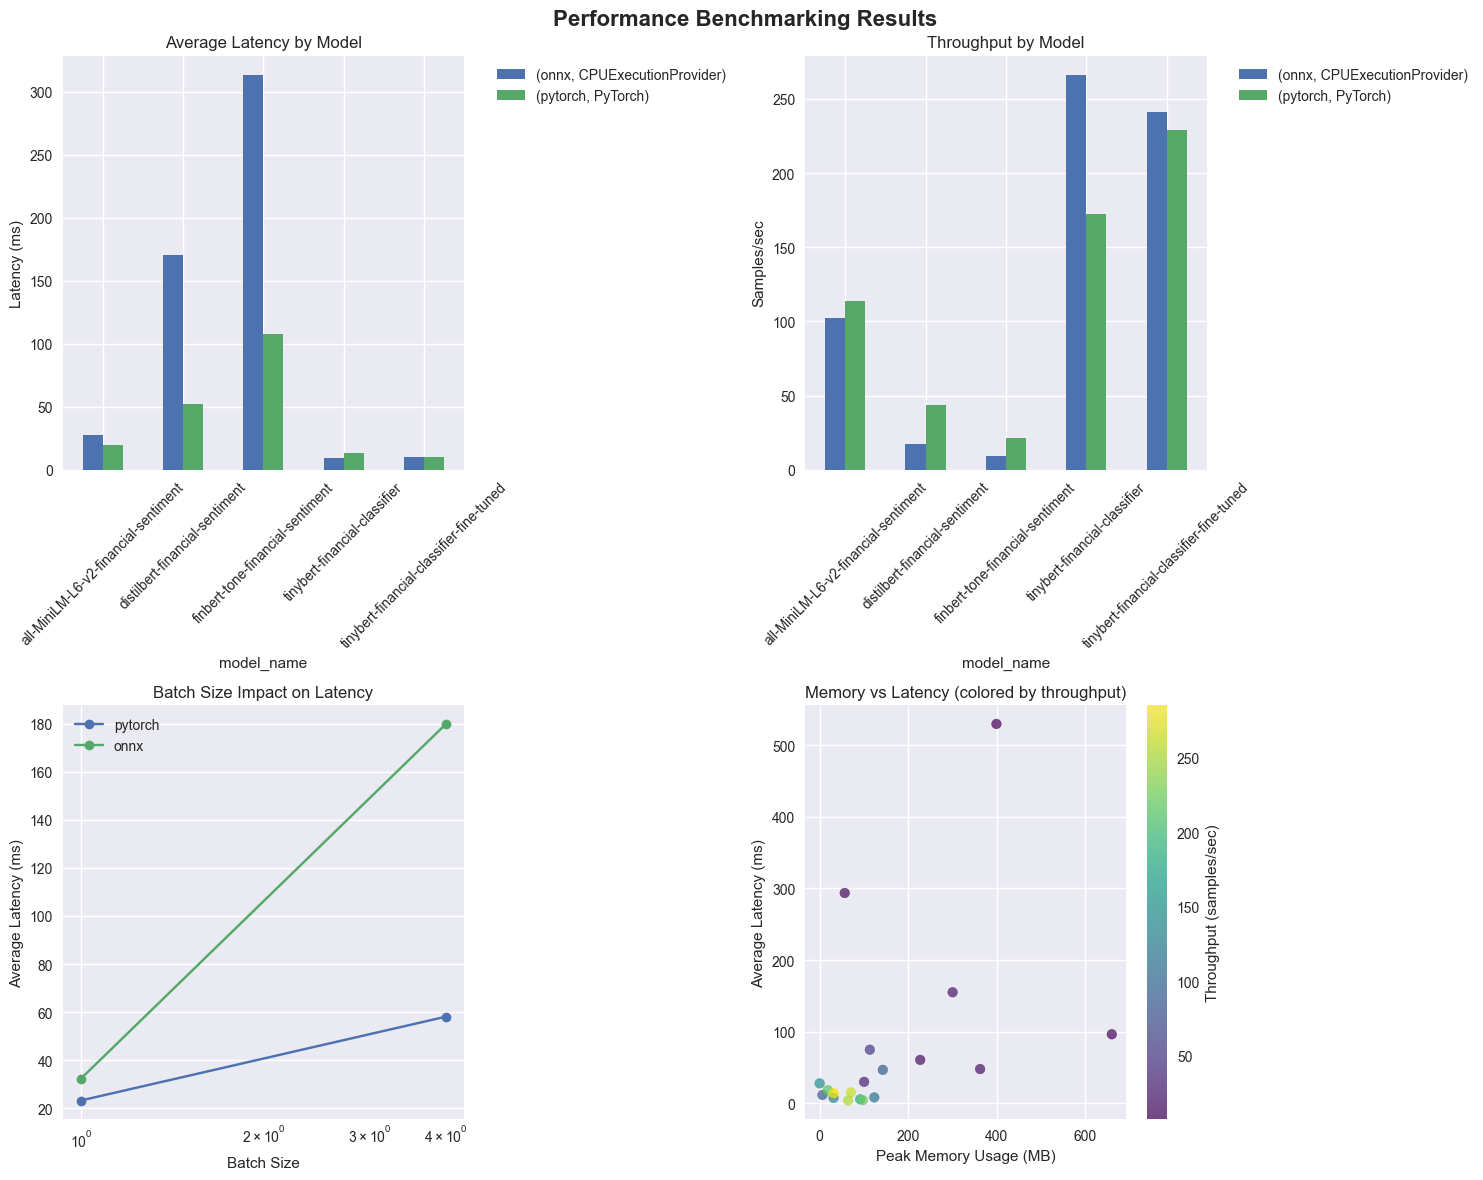

2025-08-09 21:49:28,619 - pipeline.benchmarking - INFO - Results visualization completed


In [6]:
# Results Analysis and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(f"\n📊 Results Analysis:")
print(f"{'='*80}")

# Create DataFrame from results with comprehensive metrics
results_data = []
for result in all_results:
    results_data.append({
        'model_name': result.model_name,
        'model_type': result.model_type,
        'provider': result.provider,
        'batch_size': result.batch_size,
        'avg_latency_ms': result.avg_latency_ms,
        'std_latency_ms': result.std_latency_ms,
        'min_latency_ms': result.min_latency_ms,
        'max_latency_ms': result.max_latency_ms,
        'p50_latency_ms': result.p50_latency_ms,
        'p95_latency_ms': result.p95_latency_ms,
        'p99_latency_ms': result.p99_latency_ms,
        'throughput_samples_per_sec': result.throughput_samples_per_sec,
        'peak_memory_mb': result.peak_memory_mb,
        'avg_memory_mb': result.avg_memory_mb,
        'memory_overhead_mb': result.memory_overhead_mb,
        'model_size_mb': result.model_size_mb,
        'accuracy': result.accuracy,
        'f1_score': result.f1_score,
        'validation_samples': result.validation_samples,
        # Calculated efficiency metrics
        'efficiency_score': result.throughput_samples_per_sec / result.model_size_mb if result.model_size_mb > 0 else None,
        'latency_stability': result.std_latency_ms / result.avg_latency_ms if result.avg_latency_ms > 0 and result.std_latency_ms else None,
        'memory_efficiency': result.throughput_samples_per_sec / result.peak_memory_mb if result.peak_memory_mb > 0 else None
    })

df_results = pd.DataFrame(results_data)
print(f"📋 Created results DataFrame with {len(df_results)} entries")

# Display best performers with enhanced analysis
print(f"\n🏆 Best Performers:")
print(f"{'='*60}")

# Best latency
best_latency_row = df_results.loc[df_results['avg_latency_ms'].idxmin()]
print(f"⚡ Lowest Latency: {best_latency_row['avg_latency_ms']:.2f}ms")
print(f"   📊 Model: {best_latency_row['model_name']}")
print(f"   🔧 Config: {best_latency_row['model_type']}-{best_latency_row['provider']}")
print(f"   📦 Batch: {best_latency_row['batch_size']}")
print(f"   🚀 Throughput: {best_latency_row['throughput_samples_per_sec']:.1f} samples/sec")
print(f"   💾 Memory: {best_latency_row['peak_memory_mb']:.1f}MB")
print(f"   📏 Model Size: {best_latency_row['model_size_mb']:.1f}MB")

# Best throughput
best_throughput_row = df_results.loc[df_results['throughput_samples_per_sec'].idxmax()]
print(f"\n🚀 Highest Throughput: {best_throughput_row['throughput_samples_per_sec']:.1f} samples/sec")
print(f"   📊 Model: {best_throughput_row['model_name']}")
print(f"   🔧 Config: {best_throughput_row['model_type']}-{best_throughput_row['provider']}")
print(f"   📦 Batch: {best_throughput_row['batch_size']}")
print(f"   ⚡ Latency: {best_throughput_row['avg_latency_ms']:.2f}ms")
print(f"   💾 Memory: {best_throughput_row['peak_memory_mb']:.1f}MB")
print(f"   📏 Model Size: {best_throughput_row['model_size_mb']:.1f}MB")

# Best efficiency (throughput per MB of model)
df_results['efficiency'] = df_results['throughput_samples_per_sec'] / df_results['model_size_mb']
best_efficiency_row = df_results.loc[df_results['efficiency'].idxmax()]
print(f"\n⚙️ Best Efficiency: {best_efficiency_row['efficiency']:.1f} samples/sec/MB")
print(f"   📊 Model: {best_efficiency_row['model_name']}")
print(f"   🔧 Config: {best_efficiency_row['model_type']}-{best_efficiency_row['provider']}")
print(f"   📦 Batch: {best_efficiency_row['batch_size']}")
print(f"   🚀 Throughput: {best_efficiency_row['throughput_samples_per_sec']:.1f} samples/sec")
print(f"   📏 Model Size: {best_efficiency_row['model_size_mb']:.1f}MB")

# Additional best performer metrics
# Best accuracy (if available)
if df_results['accuracy'].notna().any():
    best_accuracy_row = df_results.loc[df_results['accuracy'].idxmax()]
    print(f"\n🎯 Highest Accuracy: {best_accuracy_row['accuracy']:.4f}")
    print(f"   📊 Model: {best_accuracy_row['model_name']}")
    print(f"   🔧 Config: {best_accuracy_row['model_type']}-{best_accuracy_row['provider']}")
    print(f"   📦 Batch: {best_accuracy_row['batch_size']}")
    print(f"   ⚡ Latency: {best_accuracy_row['avg_latency_ms']:.2f}ms")
    if best_accuracy_row['f1_score']:
        print(f"   🎯 F1-Score: {best_accuracy_row['f1_score']:.4f}")

# Best stability (lowest coefficient of variation)
if df_results['latency_stability'].notna().any():
    best_stability_row = df_results.loc[df_results['latency_stability'].idxmin()]
    print(f"\n📊 Most Stable Latency: {best_stability_row['latency_stability']:.4f} CV")
    print(f"   📊 Model: {best_stability_row['model_name']}")
    print(f"   🔧 Config: {best_stability_row['model_type']}-{best_stability_row['provider']}")
    print(f"   📦 Batch: {best_stability_row['batch_size']}")
    print(f"   ⚡ Latency: {best_stability_row['avg_latency_ms']:.2f}ms ±{best_stability_row['std_latency_ms']:.2f}ms")

# Best memory efficiency
if df_results['memory_efficiency'].notna().any():
    best_mem_eff_row = df_results.loc[df_results['memory_efficiency'].idxmax()]
    print(f"\n💾 Best Memory Efficiency: {best_mem_eff_row['memory_efficiency']:.1f} samples/sec/MB")
    print(f"   📊 Model: {best_mem_eff_row['model_name']}")
    print(f"   🔧 Config: {best_mem_eff_row['model_type']}-{best_mem_eff_row['provider']}")
    print(f"   📦 Batch: {best_mem_eff_row['batch_size']}")
    print(f"   💾 Memory: {best_mem_eff_row['peak_memory_mb']:.1f}MB")

# Best accuracy (if available)
if df_results['accuracy'].notna().any():
    best_accuracy_row = df_results.loc[df_results['accuracy'].idxmax()]
    print(f"\n🎯 Highest Accuracy: {best_accuracy_row['accuracy']:.4f}")
    print(f"   Model: {best_accuracy_row['model_name']} ({best_accuracy_row['model_type']}-{best_accuracy_row['provider']})")
    print(f"   Batch: {best_accuracy_row['batch_size']}, Latency: {best_accuracy_row['avg_latency_ms']:.2f}ms")

# Performance by model type with enhanced metrics
print(f"\n📊 Performance by Model Type:")
print(f"{'='*60}")
type_summary = df_results.groupby('model_type').agg({
    'avg_latency_ms': ['mean', 'min', 'max', 'std'],
    'throughput_samples_per_sec': ['mean', 'min', 'max', 'std'],
    'peak_memory_mb': ['mean', 'min', 'max'],
    'model_size_mb': ['mean', 'min', 'max'],
    'accuracy': 'mean'
}).round(3)

for model_type in type_summary.index:
    print(f"\n🔥 {model_type.upper()}:")
    print(f"   ⚡ Latency: {type_summary.loc[model_type, ('avg_latency_ms', 'mean')]:.2f}ms ±{type_summary.loc[model_type, ('avg_latency_ms', 'std')]:.2f}ms")
    print(f"      Range: {type_summary.loc[model_type, ('avg_latency_ms', 'min')]:.2f}ms - {type_summary.loc[model_type, ('avg_latency_ms', 'max')]:.2f}ms")
    print(f"   🚀 Throughput: {type_summary.loc[model_type, ('throughput_samples_per_sec', 'mean')]:.1f} ±{type_summary.loc[model_type, ('throughput_samples_per_sec', 'std')]:.1f} samples/sec")
    print(f"      Range: {type_summary.loc[model_type, ('throughput_samples_per_sec', 'min')]:.1f} - {type_summary.loc[model_type, ('throughput_samples_per_sec', 'max')]:.1f} samples/sec")
    print(f"   💾 Memory: {type_summary.loc[model_type, ('peak_memory_mb', 'mean')]:.1f}MB avg ({type_summary.loc[model_type, ('peak_memory_mb', 'min')]:.1f}-{type_summary.loc[model_type, ('peak_memory_mb', 'max')]:.1f}MB)")
    print(f"   📏 Model Size: {type_summary.loc[model_type, ('model_size_mb', 'mean')]:.1f}MB avg ({type_summary.loc[model_type, ('model_size_mb', 'min')]:.1f}-{type_summary.loc[model_type, ('model_size_mb', 'max')]:.1f}MB)")
    if not pd.isna(type_summary.loc[model_type, ('accuracy', 'mean')]):
        print(f"   🎯 Accuracy: {type_summary.loc[model_type, ('accuracy', 'mean')]:.4f}")

# Model-specific analysis
print(f"\n🤖 Per-Model Analysis:")
print(f"{'='*60}")
model_summary = df_results.groupby('model_name').agg({
    'avg_latency_ms': 'min',
    'throughput_samples_per_sec': 'max',
    'peak_memory_mb': 'mean',
    'model_size_mb': 'first'
}).round(2)

for model_name in model_summary.index:
    print(f"\n📊 {model_name}:")
    print(f"   ⚡ Best Latency: {model_summary.loc[model_name, 'avg_latency_ms']:.2f}ms")
    print(f"   🚀 Best Throughput: {model_summary.loc[model_name, 'throughput_samples_per_sec']:.1f} samples/sec")
    print(f"   💾 Avg Memory: {model_summary.loc[model_name, 'peak_memory_mb']:.1f}MB")
    print(f"   📏 Model Size: {model_summary.loc[model_name, 'model_size_mb']:.1f}MB")
    
    # Find best configuration for this model
    model_data = df_results[df_results['model_name'] == model_name]
    best_config = model_data.loc[model_data['avg_latency_ms'].idxmin()]
    print(f"   🔧 Best Config: {best_config['model_type']}-{best_config['provider']} (batch={best_config['batch_size']})")

# Create visualizations
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance Benchmarking Results', fontsize=16, fontweight='bold')

# 1. Latency comparison
ax1 = axes[0, 0]
df_pivot_latency = df_results.pivot_table(values='avg_latency_ms', index='model_name', 
                                          columns=['model_type', 'provider'], aggfunc='mean')
df_pivot_latency.plot(kind='bar', ax=ax1, rot=45)
ax1.set_title('Average Latency by Model')
ax1.set_ylabel('Latency (ms)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Throughput comparison  
ax2 = axes[0, 1]
df_pivot_throughput = df_results.pivot_table(values='throughput_samples_per_sec', index='model_name',
                                             columns=['model_type', 'provider'], aggfunc='mean')
df_pivot_throughput.plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('Throughput by Model')
ax2.set_ylabel('Samples/sec')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Batch size impact on latency
ax3 = axes[1, 0]
for model_type in df_results['model_type'].unique():
    subset = df_results[df_results['model_type'] == model_type]
    batch_latency = subset.groupby('batch_size')['avg_latency_ms'].mean()
    ax3.plot(batch_latency.index, batch_latency.values, marker='o', label=model_type)
ax3.set_title('Batch Size Impact on Latency')
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Average Latency (ms)')
ax3.legend()
ax3.set_xscale('log')

# 4. Memory usage vs performance
ax4 = axes[1, 1]
scatter = ax4.scatter(df_results['peak_memory_mb'], df_results['avg_latency_ms'], 
                      c=df_results['throughput_samples_per_sec'], cmap='viridis', alpha=0.7)
ax4.set_title('Memory vs Latency (colored by throughput)')
ax4.set_xlabel('Peak Memory Usage (MB)')
ax4.set_ylabel('Average Latency (ms)')
plt.colorbar(scatter, ax=ax4, label='Throughput (samples/sec)')

plt.tight_layout()
plt.show()

logger.info("Results visualization completed")

In [ ]:
# Save Results
import json
from pathlib import Path

print(f"\n💾 Saving Results:")
print(f"{'='*80}")

# Create results directory for Colab
results_dir = Path("results")  # Use local path for Colab
results_dir.mkdir(exist_ok=True)

# Generate filename with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
base_filename = f"benchmark_results_generalized_{timestamp}"

# 1. Save CSV results
csv_path = results_dir / f"{base_filename}.csv"
df_results.to_csv(csv_path, index=False)
print(f"📊 CSV results saved: {csv_path}")

# 2. Save detailed JSON results
json_results = {
    'benchmark_summary': benchmark_summary,
    'detailed_results': [result.__dict__ for result in all_results],
    'performance_summary': {
        'best_latency': {
            'value': float(best_latency_row['avg_latency_ms']),
            'model': best_latency_row['model_name'],
            'config': f"{best_latency_row['model_type']}-{best_latency_row['provider']}",
            'batch_size': int(best_latency_row['batch_size'])
        },
        'best_throughput': {
            'value': float(best_throughput_row['throughput_samples_per_sec']),
            'model': best_throughput_row['model_name'],
            'config': f"{best_throughput_row['model_type']}-{best_throughput_row['provider']}",
            'batch_size': int(best_throughput_row['batch_size'])
        }
    }
}

# Add accuracy summary if available
if df_results['accuracy'].notna().any():
    json_results['performance_summary']['best_accuracy'] = {
        'value': float(best_accuracy_row['accuracy']),
        'model': best_accuracy_row['model_name'],
        'config': f"{best_accuracy_row['model_type']}-{best_accuracy_row['provider']}",
        'batch_size': int(best_accuracy_row['batch_size'])
    }

json_path = results_dir / f"{base_filename}.json"
with open(json_path, 'w') as f:
    json.dump(json_results, f, indent=2, default=str)
print(f"📋 JSON results saved: {json_path}")

# 3. Save performance summary report
report_path = results_dir / f"{base_filename}_summary.txt"
with open(report_path, 'w') as f:
    f.write("Performance Benchmarking Summary Report\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Configuration: {json_results['benchmark_summary']['configuration']}\n\n")
    
    f.write("Best Performers:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Lowest Latency: {best_latency_row['avg_latency_ms']:.2f}ms\n")
    f.write(f"  Model: {best_latency_row['model_name']} ({best_latency_row['model_type']}-{best_latency_row['provider']})\n")
    f.write(f"  Batch: {best_latency_row['batch_size']}\n\n")
    
    f.write(f"Highest Throughput: {best_throughput_row['throughput_samples_per_sec']:.1f} samples/sec\n")
    f.write(f"  Model: {best_throughput_row['model_name']} ({best_throughput_row['model_type']}-{best_throughput_row['provider']})\n")
    f.write(f"  Batch: {best_throughput_row['batch_size']}\n\n")
    
    if df_results['accuracy'].notna().any():
        f.write(f"Highest Accuracy: {best_accuracy_row['accuracy']:.4f}\n")
        f.write(f"  Model: {best_accuracy_row['model_name']} ({best_accuracy_row['model_type']}-{best_accuracy_row['provider']})\n")
        f.write(f"  Batch: {best_accuracy_row['batch_size']}\n\n")
    
    f.write("Performance by Model Type:\n")
    f.write("-" * 30 + "\n")
    for model_type in type_summary.index:
        f.write(f"{model_type.upper()}:\n")
        f.write(f"  Avg Latency: {type_summary.loc[model_type, ('avg_latency_ms', 'mean')]:.2f}ms\n")
        f.write(f"  Avg Throughput: {type_summary.loc[model_type, ('throughput_samples_per_sec', 'mean')]:.1f} samples/sec\n")
        if not pd.isna(type_summary.loc[model_type, ('accuracy', 'mean')]):
            f.write(f"  Avg Accuracy: {type_summary.loc[model_type, ('accuracy', 'mean')]:.4f}\n")
        f.write("\n")

print(f"📄 Summary report saved: {report_path}")

# 4. Save plot
plot_path = results_dir / f"{base_filename}_plots.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"📈 Plots saved: {plot_path}")

# 5. Update state manager with latest results
try:
    state.save_state('benchmark_results', {
        'latest_run': {
            'timestamp': timestamp,
            'csv_path': str(csv_path),
            'json_path': str(json_path),
            'report_path': str(report_path),
            'plot_path': str(plot_path)
        },
        'summary': json_results['performance_summary'],
        'models_benchmarked': list(available_models.keys()),
        'successful_benchmarks': successful_benchmarks,
        'total_benchmarks': total_benchmarks
    })
    print(f"💾 State updated with benchmark results")
except Exception as e:
    logger.warning(f"Failed to update state: {e}")

# Display completion summary
print(f"\n🎉 Benchmarking Complete!")
print(f"{'='*80}")
print(f"📊 Results available in: {results_dir}")
print(f"📈 CSV: {csv_path.name}")
print(f"📋 JSON: {json_path.name}")
print(f"📄 Report: {report_path.name}")
print(f"🖼️ Plots: {plot_path.name}")

logger.info(f"Comprehensive benchmarking completed successfully. Results saved to {results_dir}")
print(f"\n✅ All benchmarking tasks completed successfully!")

2025-08-09 21:49:28,716 - pipeline.benchmarking - WARNING - Failed to update state: StateManager.save_state() takes 1 positional argument but 3 were given
2025-08-09 21:49:28,717 - pipeline.benchmarking - INFO - Comprehensive benchmarking completed successfully. Results saved to ../results



💾 Saving Results:
📊 CSV results saved: ../results/benchmark_results_generalized_20250809_214928.csv
📋 JSON results saved: ../results/benchmark_results_generalized_20250809_214928.json
📄 Summary report saved: ../results/benchmark_results_generalized_20250809_214928_summary.txt
📈 Plots saved: ../results/benchmark_results_generalized_20250809_214928_plots.png

🎉 Benchmarking Complete!
📊 Results available in: ../results
📈 CSV: benchmark_results_generalized_20250809_214928.csv
📋 JSON: benchmark_results_generalized_20250809_214928.json
📄 Report: benchmark_results_generalized_20250809_214928_summary.txt
🖼️ Plots: benchmark_results_generalized_20250809_214928_plots.png

✅ All benchmarking tasks completed successfully!


<Figure size 800x550 with 0 Axes>

# 📥 Download Results From Colab

After completing the benchmarking, you'll want to download your results. The files are saved in the `results` directory.

In [ ]:
# Code to download results from Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    
    # Zip results directory for easy download
    !zip -r benchmark_results.zip results/
    
    # Download the zip file
    files.download('benchmark_results.zip')
    print("✅ Results downloaded as benchmark_results.zip")
    
    # You can also download individual files
    # files.download(f'results/{csv_path.name}')
    # files.download(f'results/{json_path.name}')
    # files.download(f'results/{report_path.name}')
    # files.download(f'results/{plot_path.name}')
else:
    print("📄 Results are available in the local results/ directory")